In [1]:
import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, GroupRidgeCV

from simulation import generate_dataset

In [2]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord')
sns.set_theme(style='whitegrid')

In [3]:
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 1000
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

In [4]:
alphas = np.logspace(-4, 4, 10)
cv = 10
score_func = himalaya.scoring.r2_score

In [5]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar, construction_method="random")

CUDARuntimeError: cudaErrorUnknown: unknown error

train joint model

In [6]:
banded_solver_params = dict(n_iter=10, alphas=alphas, progress_bar=False, warn=False, score_func=score_func,
                            n_targets_batch=1000)
joint_model = GroupRidgeCV(groups="input", solver_params=banded_solver_params)

In [7]:
joint_model.fit([x[:n_samples_train] for x in Xs], Y[:n_samples_train])
joint_score = joint_model.score([x[n_samples_train:] for x in Xs], Y[n_samples_train:])
joint_score = backend.to_numpy(joint_score)

<Axes: ylabel='Count'>

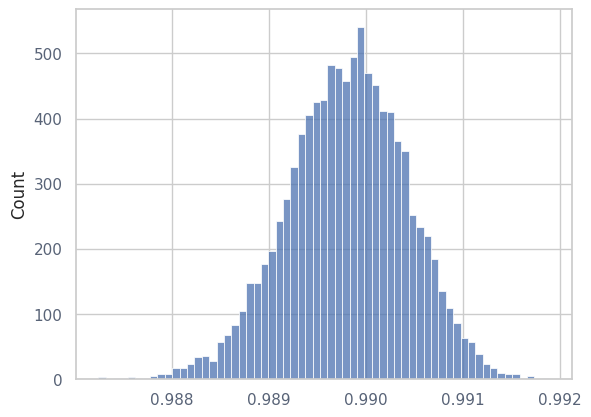

In [8]:
sns.histplot(joint_score)

train single models

In [9]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)

Fit and predict for i = 0

In [10]:
single_model.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
score_0 = single_model.score(Xs[0][n_samples_train:], Y[n_samples_train:])
score_0 = backend.to_numpy(score_0)

<Axes: ylabel='Count'>

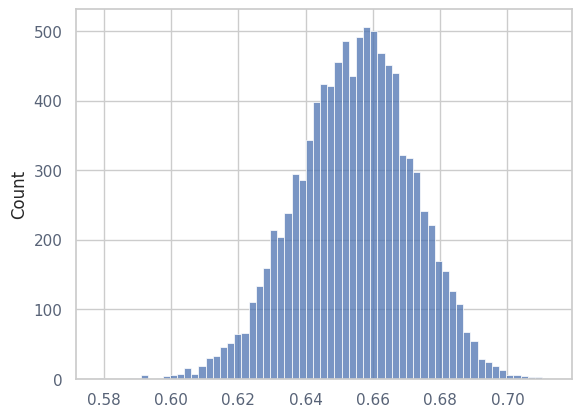

In [11]:
sns.histplot(score_0)

Fit and predict for i = 1

In [12]:
single_model.fit(Xs[1][:n_samples_train], Y[:n_samples_train])
score_1 = single_model.score(Xs[1][n_samples_train:], Y[n_samples_train:])
score_1 = backend.to_numpy(score_1)

<Axes: ylabel='Count'>

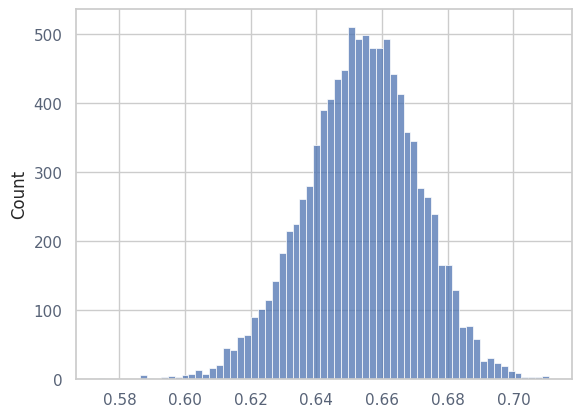

In [13]:
sns.histplot(score_1)

Calculate unique and shared variance

In [14]:
shared = (score_0 + score_1) - joint_score
x0_unique = score_0 - shared
x1_unique = score_1 - shared

In [15]:
shared = backend.to_numpy(shared)
x0_unique = backend.to_numpy(x0_unique)
x1_unique = backend.to_numpy(x1_unique)

create pandas dataset of all scores for analysis

In [43]:
scores = pd.DataFrame(
    # create columnar data
    [joint_score, score_0, score_1, shared, x0_unique, x1_unique],
    index=[r"$X_1\cupX_2$", r"$X_1$", "$X_2$", r"$X_1\cap X_2$", r"$X_{1_{unique}}$", r"$X_{2_{unique}}$"]
)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
$X_1\cupX_2$,0.989412,0.989811,0.989950,0.990274,0.989875,0.990146,0.989626,0.989543,0.990607,0.990460,...,0.988636,0.989967,0.991234,0.990074,0.989114,0.990748,0.990321,0.989932,0.990286,0.988739
$X_1$,0.647482,0.650580,0.670297,0.630139,0.644846,0.685300,0.669138,0.658863,0.655077,0.671607,...,0.642484,0.647680,0.650763,0.657875,0.642877,0.682153,0.658181,0.649661,0.658292,0.626931
$X_2$,0.665439,0.635235,0.666816,0.634170,0.689601,0.656441,0.637656,0.674132,0.663361,0.653111,...,0.622268,0.651998,0.630834,0.653003,0.664780,0.664761,0.648080,0.678847,0.682880,0.647605
$X_1\capX_2$,0.323510,0.296003,0.347163,0.274035,0.344572,0.351595,0.317168,0.343453,0.327831,0.334258,...,0.276117,0.309711,0.290363,0.320804,0.318542,0.356166,0.315939,0.338577,0.350886,0.285797
$X_{1_{unique}}$,0.323973,0.354576,0.323133,0.356105,0.300274,0.333705,0.351970,0.315410,0.327247,0.337349,...,0.366367,0.337969,0.360400,0.337071,0.324334,0.325987,0.342242,0.311085,0.307406,0.341133


In [44]:
sns.catplot(
    data=scores.T, kind="bar", height=6, aspect=2,
    palette=["C0", "C0", "C0", "C1", "C1", "C1"]  # Define colors: one for joint/X₁/X₂, one for unique/shared
)

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(scores.index):  # iterate over rows in the DataFrame
    xmin = idx / len(scores.index)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.index)  # Calculate xmax for each bar
    plt.axhline(scores.loc[column].max(), linestyle='--', alpha=0.7,
                xmin=xmin, xmax=xmax, label=fr'Theoretically achievable $R^2$' if idx == 0 else "")

# Ensure the legend is displayed properly
plt.legend(title="Maximum Values", bbox_to_anchor=(1.05, 1), loc='upper left')

ValueError: 
X_1\cupX_2
   ^
ParseFatalException: Unknown symbol: \cupX, found '\'  (at char 3), (line:1, col:4)

Error in callback <function _draw_all_if_interactive at 0x7bda0892d440> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
X_1\cupX_2
   ^
ParseFatalException: Unknown symbol: \cupX, found '\'  (at char 3), (line:1, col:4)

ValueError: 
X_1\cupX_2
   ^
ParseFatalException: Unknown symbol: \cupX, found '\'  (at char 3), (line:1, col:4)

<Figure size 1200x600 with 1 Axes>